In [1]:
def select_function(ct_str, key):
    # DES SBox 1
    SBox1 = [
        [14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7],
        [0, 15, 7, 4, 14, 2, 13, 1, 10, 6, 12, 11, 9, 5, 3, 8],
        [4, 1, 14, 8, 13, 6, 2, 11, 15, 12, 9, 7, 3, 10, 5, 0],
        [15, 12, 8, 2, 4, 9, 1, 7, 5, 11, 3, 14, 10, 0, 6, 13]
    ]

    # Expansion permutation table (DES standard)
    E = [31, 0, 1, 2, 3, 4, 3, 4, 5, 6, 7, 8, 7, 8, 9, 10, 11, 12, 
        11, 12, 13, 14, 15, 16, 15, 16, 17, 18, 19, 20, 19, 20, 21, 
        22, 23, 24, 23, 24, 25, 26, 27, 28, 27, 28, 29, 30, 31, 0]

    # Convert hex ciphertext to binary
    ciphertext = int(ct_str, 16)
    L16 = (ciphertext >> 32) & 0xFFFFFFFF
    R16 = ciphertext & 0xFFFFFFFF

    # R15 is L16 in the DES Feistel structure
    R15 = L16

    # Apply Expansion (E) to R15
    def apply_expansion(r):
        expanded = 0
        for i, bit in enumerate(E):
            expanded |= ((r >> bit) & 1) << (47 - i)
        return expanded

    expanded_R15 = apply_expansion(R15)

    # XOR first 6 bits of expanded R15 with the key
    sbox_input = (expanded_R15 >> 42) & 0x3F  # First 6 bits of expanded_R15
    sbox_input ^= key

    # Compute SBox output
    row = ((sbox_input >> 5) & 1) * 2 + (sbox_input & 1)  # Row from outer bits
    col = (sbox_input >> 1) & 0xF  # Column from middle 4 bits
    sbox_output = SBox1[row][col]

    return (sbox_output >> 3) & 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
trace_df = pd.read_csv("processed_trace_data.csv")

# Constants
NUM_KEYS = 64  # Keys range from 0 to 63
kc = 60  # Known correct key index
ciphertexts = trace_df['Ciphertext']

V_map = {}

for i in range(NUM_KEYS):
    print(f"Precomputed select function for key: {i}")
    V_map[i] = np.array([select_function(ct, i) for ct in ciphertexts])

# Compute confusion coefficients k, K, and K*
def compute_confusion_coefficients(kc, ciphertexts):
    # Initialize confusion vector and matrices
    K = np.zeros((NUM_KEYS, NUM_KEYS))  # Confusion matrix K
    
    # Compute V|kc
    V_kc = V_map[kc]
    
    for kgi in range(NUM_KEYS):  # Iterate over candidate keys kgi
        V_kgi = V_map[kgi]

        for kgj in range(NUM_KEYS):  # Iterate over candidate keys kgj
            print(f"k_gi={kgi}, k_gj={kgj}")
            V_kgj = V_map[kgj]
        
            three_way_kappa = 0.5*(np.mean((V_kc - V_kgi) ** 2) + np.mean((V_kc - V_kgj) ** 2) - np.mean((V_kgi - V_kgj) ** 2))
            K[kgi, kgj] = three_way_kappa  # K(kc, kgi, kgj)
    
    return K

# Compute confusion coefficients
K = compute_confusion_coefficients(kc, ciphertexts)

Precomputed select function for key: 0
Precomputed select function for key: 1
Precomputed select function for key: 2
Precomputed select function for key: 3
Precomputed select function for key: 4
Precomputed select function for key: 5
Precomputed select function for key: 6
Precomputed select function for key: 7
Precomputed select function for key: 8
Precomputed select function for key: 9
Precomputed select function for key: 10
Precomputed select function for key: 11
Precomputed select function for key: 12
Precomputed select function for key: 13
Precomputed select function for key: 14
Precomputed select function for key: 15
Precomputed select function for key: 16
Precomputed select function for key: 17
Precomputed select function for key: 18
Precomputed select function for key: 19
Precomputed select function for key: 20
Precomputed select function for key: 21
Precomputed select function for key: 22
Precomputed select function for key: 23
Precomputed select function for key: 24
Precompute

In [3]:
import pickle

# Save the arrays using pickle
def save_confusion_data_pickle(K, output_path="confusion_Kc.pkl"):
    with open(output_path, "wb") as f:
        pickle.dump(K, f)
    print(f"Confusion data saved to {output_path}")

# Load the arrays using pickle
def load_confusion_data_pickle(input_path="confusion_Kc.pkl"):
    with open(input_path, "rb") as f:
        data = pickle.load(f)
    print(f"Confusion data loaded from {input_path}")
    return data

# Save the computed data
save_confusion_data_pickle(K, f"confusion_Kc={kc}.pkl")

Confusion data saved to confusion_Kc=60.pkl


Confusion data loaded from confusion_Kc=59.pkl


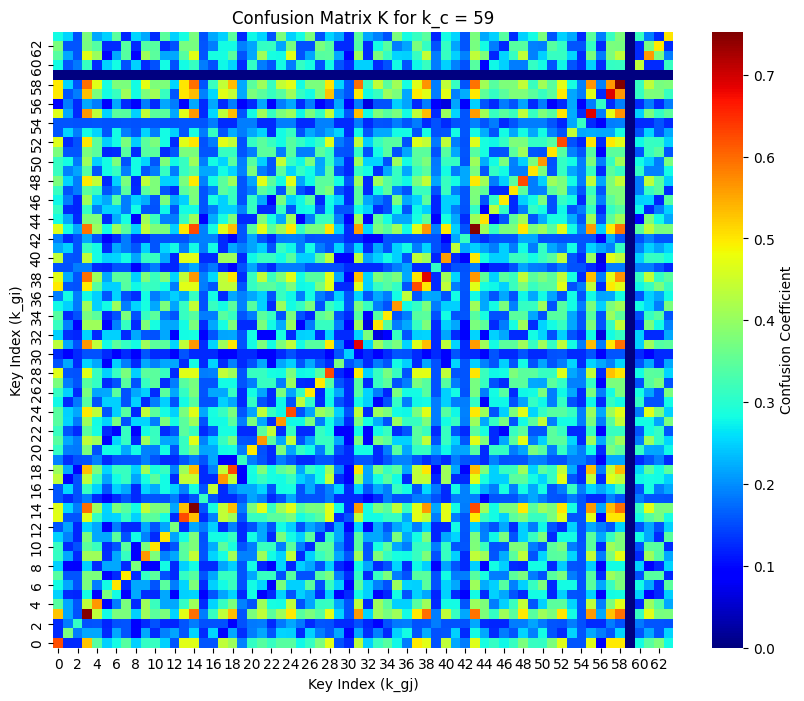

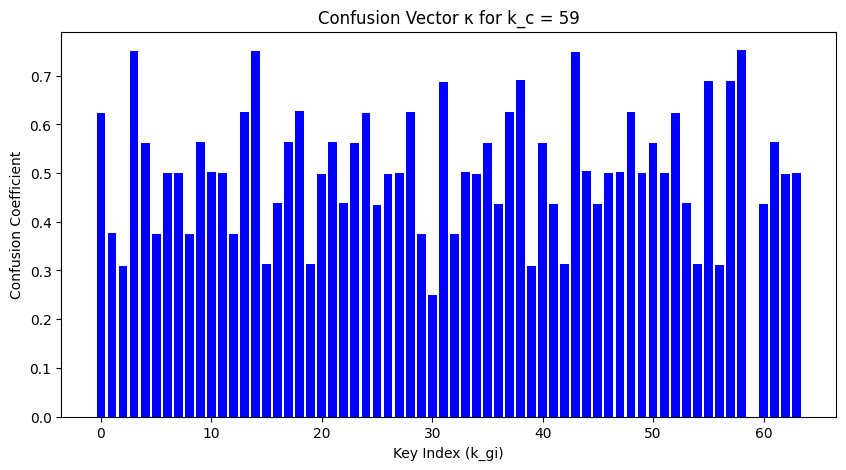

Confusion data loaded from confusion_Kc=60.pkl


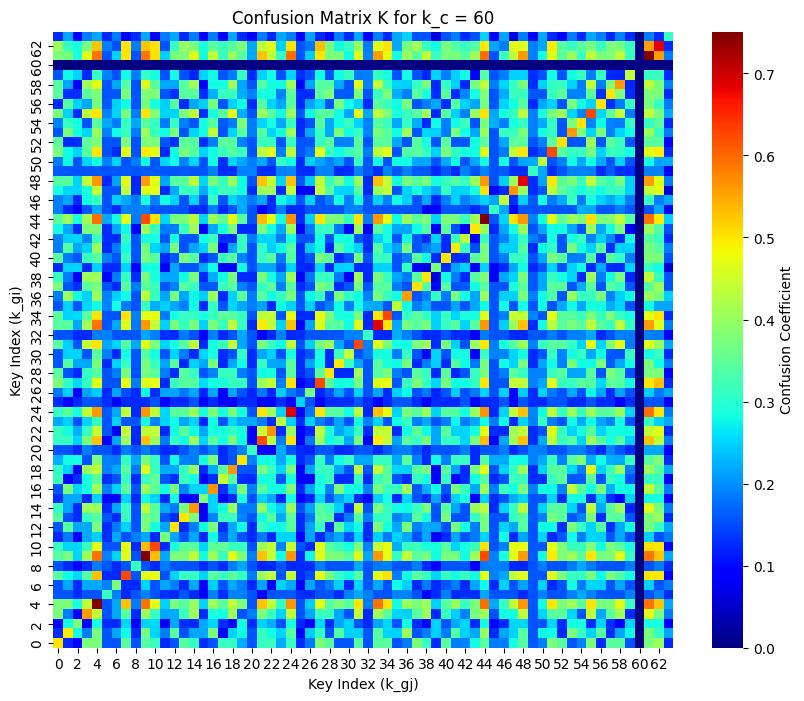

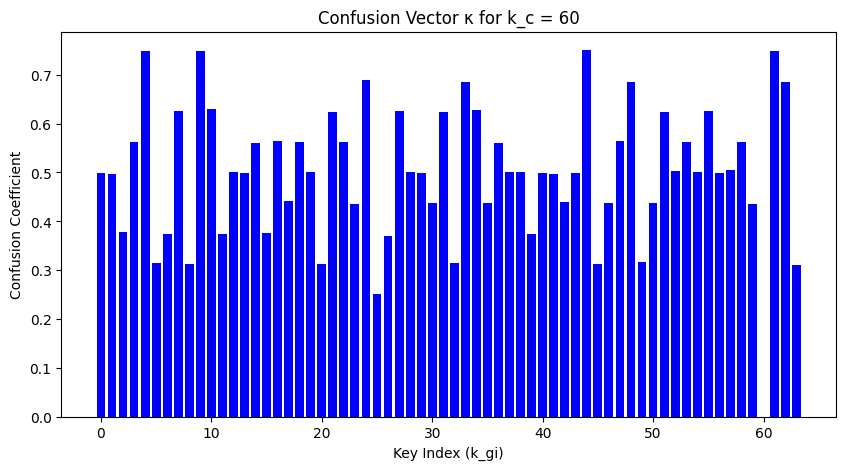

In [4]:
K = load_confusion_data_pickle(input_path="confusion_Kc=59.pkl")

# Visualize confusion matrix K with flipped y-axis and custom color scale
plt.figure(figsize=(10, 8))
sns.heatmap(K, annot=False, fmt=".2f", cmap="jet", cbar_kws={'label': 'Confusion Coefficient'})
plt.title(f"Confusion Matrix K for k_c = 59")
plt.xlabel("Key Index (k_gj)")
plt.ylabel("Key Index (k_gi)")
plt.gca().invert_yaxis()  # Flip the y-axis
plt.show()

# Visualize the confusion vector κ
plt.figure(figsize=(10, 5))
plt.bar(range(NUM_KEYS), np.diag(K), color='blue')  # Color added for consistency
plt.title(f"Confusion Vector κ for k_c = 59")
plt.xlabel("Key Index (k_gi)")
plt.ylabel("Confusion Coefficient")
plt.show()

K = load_confusion_data_pickle(input_path="confusion_Kc=60.pkl")

# Visualize confusion matrix K with flipped y-axis and custom color scale
plt.figure(figsize=(10, 8))
sns.heatmap(K, annot=False, fmt=".2f", cmap="jet", cbar_kws={'label': 'Confusion Coefficient'})
plt.title(f"Confusion Matrix K for k_c = 60")
plt.xlabel("Key Index (k_gj)")
plt.ylabel("Key Index (k_gi)")
plt.gca().invert_yaxis()  # Flip the y-axis
plt.show()

# Visualize the confusion vector κ
plt.figure(figsize=(10, 5))
plt.bar(range(NUM_KEYS), np.diag(K), color='blue')  # Color added for consistency
plt.title(f"Confusion Vector κ for k_c = 60")
plt.xlabel("Key Index (k_gi)")
plt.ylabel("Confusion Coefficient")
plt.show()